<a href="https://colab.research.google.com/github/bryancrigger/IST664---Natural-Language-Processing/blob/main/NLP_Project_Detecting_SPAM_Emails_with_NLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

For this project, the team was provided with a dataset from the Enron public email corpus. The corpus consisted primarily of legitimate emails with some spam emails already present in the corpus. Additional spam emails were added into the email corpus in order to have a sufficient number of spam examples to train a classifier. 

The goal of the project was to determine the most effective features and models to classify spam versus legitimate emails. Throughout the course of the project, legitimate emails are refered to as "ham" emails. The process required the team to develop features that were applied to the the spam/ham email classification task and to demonstrate, through the use of experiments, which sets of features and models are most effective in classifying the email data.

To complete the required tasks in this project, the team used Python scripting in combination with various Python libraries. The primary libraries used in this project include: pandas, numpy, nltk, graphviz, matplotlib, sklearn, and tensorflow.

# STEP 1: DATA PROCESSING

Before training classification models or running feature functions, the team processed and cleaned the data in order to ensure classification tasks used the highest quality and most standard data possible for training and testing. 

The first step in data processing was importing the required libraries, modules, and packages into our Python script.

## Importing required libraries, module, and packages

In [ ]:
# Import libraries

# pip install graphviz
# pip install pydotplus

import numpy as np
import pandas as pd
import sklearn
import nltk
import re
import os
import sys
import random as rd
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
import string

from nltk.probability import FreqDist
from nltk.corpus import stopwords, sentence_polarity
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.collocations import*
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz  
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from IPython.display import Image
from wordcloud import WordCloud
from google.colab import drive
# drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Pre-processing

In the processSpamHam function, the team converted the data from the provided .txt files to a workable format. The team began this process using a base of the code provided in the FinalProjectData.zip. Some of the original code was altered to return additional lists that were required for later cleaning and filtering of the data. 

In [ ]:
##TEXT PRE-PROCESSING - Reading in the data and making it into a compatible format

'''
  This program shell reads email data for the spam classification problem.
  The input to the program is the path to the Email directory "corpus" and a limit number.

  Usage:  python classifySPAM.py  <corpus directory path> <limit number>
'''

#dirPath = '/Users/aannick/Documents/Grad School/IST664/FinalProject/FinalProjectData/EmailSpamCorpora/corpus'

# function to read spam and ham files, train and test a classifier 
def processSpamHam(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  # initialize lists for spam and ham email texts
  hamtexts = []
  spamtexts = []
  os.chdir(dirPath)
  # process all files in directory that end in .txt up to the provided limit
  #    assuming that the emails are sufficiently randomized
  # output: spamtexts, hamtexts
  #    list in which each list item is an entire email stored in one string
  for file in os.listdir("./spam"):
    if (file.endswith(".txt")) and (len(spamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./spam/"+file, 'r', encoding="latin-1")
      spamtexts.append (f.read())
      f.close()
  for file in os.listdir("./ham"):
    if (file.endswith(".txt")) and (len(hamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./ham/"+file, 'r', encoding="latin-1")
      hamtexts.append (f.read())
      f.close()

  # print number emails read
  print ("Number of spam files:",len(spamtexts))
  print ("Number of ham files:",len(hamtexts))

  # output: emaildocs
  #     single list of mixed spam and ham email documents as
  #     list items are: (list of tokenized words, label)
  emaildocs = []
  # add the spam
  for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))
  # add the ham
  for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))
  
  # randomize the list
  random.shuffle(emaildocs)
  
  # print a few token lists
  """
  for email in emaildocs[:4]:
    print (email)
    print
  """

  return(emaildocs, spamtexts, hamtexts)

## Tokenizing and filtering: lowercase, regex, stopword removal

In the cleanUpCleanUp function, the team tokenized and filtered, then removed stopwords from the data. This function starts by changing all email text to lowercase and tokenizing the emails. Then it filters all symbols and numbers from the emails. Next, it removes the stop word list from the email text. And, finally, it returns nine slightly varied lists to be used in later functions.

The first set of lists return just the tokenized emails with their "spam" or "ham" label. One list is only the ham emails (hamTokens), one list is only the spam emails (spamTokens), and one list is a shuffled combination of both the spam and the ham emails (emaildocsTokenized).

The second set of lists return the tokenized emails, labeled "spam" or "ham," with all symbols and numbers removed. One list is only the ham emails with symbols/numbers removed (hamAlpha), one list is only the spam emails with symbols/numbers removed (spamAlpha), and one list is a shuffled combination of both the spam and the ham emails with symbols/numbers removed (emaildocsAlpha).

The third set of lists return the tokenized emails, labeled "spam" or "ham," with all symbols/numbers removed and with stop words removed as specified in the "stopwords" list. 

The team chose to use to nltk provided "english" stopword list with the goal of creating a classification framework that could be applied to all emails, not just the emails provided in this corpus. If the team had used a bespoke stop word list, created specifically from this dataset, it is likely the stop word list would not be as effective if new emails were added to the corpus. By using the provided NLTK "english" stop word list, which was created using a much broader corpus, the team ensured that this Python framework would be effective even if completely different email corpus data is plugged into the script. 

In addition to the NLTK "english" stop word list, the team intentionally removed common names that were found in the "To:" lines of the emails. This decision was made so that this scripting framework does not base classification decisions off of email recipients as such data will not necessarily remain an accurate method of classification if the email corpus is altered. 

Though for this project the team chose to use the provided NLTK "english" stop word list, the team included commented-out code that can be used to load a specific stop word file, if desired.

Similar to the above sets, there are three lists returned after tokenizing, filtering, and removing stopwords; one with only ham emails (hamStop), one with only spam emails (spamStop), and one with a shuffled combination of both the spam and the ham emails (emaildocsStop).

In [ ]:
def cleanUpCleanUp(emaildocs):
  # everybody do your share, everybody everywhere

  # output: spamTokens, hamTokens
  #     each list will contain tokenized words sorted by spam or ham

  # initialize word lists for all tokenized words from master emaildocs list
  # make everything lowercase for more accurate frequency analysis
  spamTokens = []
  hamTokens = []
  emaildocsTokenized = []
  for item in emaildocs:
    email = item[0]
    if item[1] == "spam":
      for word in email:
        spamTokens.append(word.lower())
    else:
      for word in email:
        hamTokens.append(word.lower())

  tokenList = []
  for item in emaildocs:
    email = item[0]
    for word in email:
      tokenList.append(word.lower())
    emaildocsTokenized.append((tokenList,item[1]))
    tokenList = []

  # regex filter
  # output: spamAlpha, hamAlpha
  #     each list will contain only words with all alphabetized chars sorted by spam or ham
  # initialize word lists for alpha words
  spamAlpha = []
  hamAlpha = []
  emaildocsAlpha = []
  pattern = re.compile('^[^a-z]+$')
  for word in hamTokens:
    if not pattern.match(word):
      hamAlpha.append(word)
  for word in spamTokens:
    if not pattern.match(word):
      spamAlpha.append(word)

  alphaList = []
  for item in emaildocsTokenized:
    emailTokenList = item[0]
    for word in emailTokenList:
      if not pattern.match(word):
        alphaList.append(word)
    emaildocsAlpha.append((alphaList,item[1]))
    alphaList = [] 

  # checkout default stopword file to see if it will accomplish desired goals
  nltk.download('stopwords')
  nltkStopwords = nltk.corpus.stopwords.words('english')
  # print(nltkStopwords)

  #adding some of our own stopwords to tailor the list to our needs
  # specifically, adding names of recipients that are showing up in most frequent
  # removing recipients so that this is helpful to all bodies of email, not just ones with those names
  moreStopwords = ['daren','hou','ect','subject','could','would','might','must','need','sha','wo','y',"'s","'d","'ll","'t","'m","'re","'ve"]
  stopwords = nltkStopwords + moreStopwords

  # using the list filtered for just alphabetic chars
  hamStop = [w for w in hamAlpha if not w in stopwords]
  spamStop = [w for w in spamAlpha if not w in stopwords]

  emaildocsStop = []
  for item in emaildocsAlpha:
    emailTokenList = item[0]
    stopList = [w for w in emailTokenList if not w in stopwords]
    emaildocsStop.append((stopList,item[1]))
    stopList = []

  # if we want to use our own stopword file, read stop word file
  """
  fstop = open('stopwordFinal.stop','r')
  stoptext = fstop.read()
  fstop.close()
  stopwords = nltk.word_tokenize(stoptext)
  """
  return(hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop)


#STEP 2: FEATURE ENGINEERING

## Feature 1: Frequency Analysis

In [ ]:
def frequencyAnalysis(hamList,spamList):
  ndist = FreqDist(hamList)
  nitems = ndist.most_common(30)
  print("\nHam Most Common Words")
  for item in nitems:
    print(item[0],'\t',item[1])
  
  ndist2 = FreqDist(spamList)
  nitems2 = ndist2.most_common(30)
  print("\nSpam Most Common Words")
  for item in nitems2:
    print(item[0],'\t',item[1])

## Feature 2: Bigram Creation and Frequency Analysis

In [ ]:
#feature function 2: bigram frequency analysis

def bigrams(hamList, spamList):
  hamFinder = nltk.collocations.BigramCollocationFinder.from_words(hamList)
  commonBigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t', bigram[1])

  spamFinder = nltk.collocations.BigramCollocationFinder.from_words(spamList)
  commonBigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t',bigram[1])

#BAG OF WORDS
#function: split data into testing and training data
#function: join tokenized email lists back into single string

#NAIVE BAYES CLASSIFICATION
#use cross-validation to obtain precision, recall, and F-measure scores
#you can choose to produce the features as a CSV file and use sklearn to train/test a classifier, using cross validation scores

#function: classify using Gaussian Naive Bayes

## Feature 3: Trigram Creation and Frequency Analysis

In [ ]:
def trigrams(hamList, spamList):
  hamFinder = nltk.collocations.TrigramCollocationFinder.from_words(hamList)
  commonTrigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t', trigram[1])

  spamFinder = nltk.collocations.TrigramCollocationFinder.from_words(spamList)
  commonTrigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t',trigram[1])

## Feature 4: Sentiment Analysis

In [ ]:
def sentimentAnalysis(spamtexts, hamtexts):
  #guidance from the following site: https://realpython.com/python-nltk-sentiment-analysis/

  # initialize sentiment analyzer included in nltk
  sia = SentimentIntensityAnalyzer()
  # initialize lists
  spamSentimentList = []
  hamSentimentList = []
  # using only the compound score from the sia, sort the emails into positive and negative lists
  # start with spam
  for email in spamtexts:
    compoundScore = sia.polarity_scores(email)["compound"]
    if compoundScore > 0:
      spamSentimentList.append((email, compoundScore, 'positive'))
    else:
      spamSentimentList.append((email, compoundScore, 'negative'))
  # now do ham
  for email in hamtexts:
    compoundScore = sia.polarity_scores(email)["compound"]
    if compoundScore > 0:
      hamSentimentList.append((email, compoundScore, 'positive'))
    else:
      hamSentimentList.append((email, compoundScore, 'negative'))
  # output: spamSentimentList, hamSentimentList
  #    each list will contain a triple tuple with tokenized email, sentiment score, "positive"/"negative"

  return (spamSentimentList, hamSentimentList)


## Feature 5: Bag of Words


In [ ]:
def trainTestSplit(emaildocsStop):
    prepList = []
    trainList = []
    testList = []
    listA = []
    # change ham = 0, spam = 1
    for email in emaildocsStop:
        if email[1] == "ham":
            listA = [email[0],0]
            prepList.append(listA)
        else:
            listA = [email[0],1]
            prepList.append(listA)
        listA = []
        
    # use numpy to get a random selection of 75% of data for training
    for item in prepList:
        if numpy.random.uniform(0,1) < 0.75:
            trainList.append(item)
        else:
            testList.append(item)
    print(len(testList))
    print(len(trainList))

    return testList, trainList

def join(testList, trainList):
    # joining our tokenized list values for Bag of Words
    joinedTestList = []
    joinedTrainList = []
    listA = []
    for email in testList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTestList.append(listA)
        listA = []

    for email in trainList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTrainList.append(listA)
        listA = []

    return joinedTestList, joinedTrainList
    
def classyClassy(joinedTestList,joinedTrainList):
    #using guidance from: https://www.shiksha.com/online-courses/articles/spam-filtering-using-bag-of-words/#sklearn
    
    justTextTrain = []
    for item in joinedTrainList:
        justTextTrain.append(item[0])
    justTextTest = []
    for item in joinedTrainList:
        justTextTest.append(item[0])
        
    justLabelTrain = []
    for item in joinedTrainList:
        justLabelTrain.append(item[1])
    justLabelTest = []
    for item in joinedTrainList:
        justLabelTest.append(item[1])
        
    vectorizer = CountVectorizer(max_features=100)
    vectorizer.fit(justTextTrain)

    print("Vocab:",vectorizer.vocabulary_)
    Xtrain = vectorizer.fit_transform(justTextTrain)
    classifier = GaussianNB()

    classifier.fit(Xtrain.toarray(), justLabelTrain)
    Xtest = vectorizer.transform(justTextTest)

    yPred = classifier.predict(Xtest.toarray())
    accuracy = accuracy_score(justLabelTest, yPred)
    print("Accuracy is: ",accuracy*100)


## Main function that runs Features 1-5


In [ ]:
def main():
  emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
  hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

  #print("Frequency Analysis using lists with symbols/numbers:")
  #frequencyAnalysis(hamTokens,spamTokens)

  #print("Frequency Analysis with symbols/numbers filtered:")
  #frequencyAnalysis(hamAlpha,spamAlpha)

  #print("Frequency Analysis with symbols/numbers filtered and stopwords applied:")
  #frequencyAnalysis(hamStop,spamStop)

  # bigrams(hamStop,spamStop)
  # trigrams(hamStop,spamStop)
  spamSentimentList, hamSentimentList = sentimentAnalysis(spamtexts, hamtexts)
  testList, trainList = trainTestSplit(emaildocsStop)
  joinedTestList, joinedTrainList = join(testList,trainList)
  classyClassy(joinedTestList, joinedTrainList)


"""
commandline interface takes a directory name with ham and spam subdirectories
   and a limit to the number of emails read each of ham and spam
It then processes the files and trains a spam detection classifier.

"""
if __name__ == '__main__':
    if (len(sys.argv) != 3):
        print ('usage: python classifySPAM_Annick.py <corpus-dir> <limit>')
        print('Note: if folder names contain spaces, directory path must be in quotes')
        sys.exit(0)
    main()


# STEP 3: EXPERIMENTS

In [ ]:
#experiment 1: use two different sets of features
#stopwords/alpha chars - compare experiment results

#experiment 2: use two different sets of features
#unigrams, bigrams, trigrams - compare experiment results

#experiment 3: use two different sets of features
#sentiment analysis - compare experiment results

#experiment 4: use two different sets of features
#vocabulary size - compare experiment results

#experiment 5: use at least two combined feature functions
#bigrams + sentiment analysis?

#experiment 6: use a new feature function that we have not covered in class
# WE DON'T HAVE THIS DONE

#experiment 7: use an advanced function
# Bryan - Using TensorFlow to Detect Spam Emails

# Other Experiments

## Multinomial Naive Bayes

In [ ]:
#this creates a function to stem the words
STEMMER=PorterStemmer()
print(STEMMER.stem("fishings"))

fish


In [ ]:
def MY_STEMMER(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [STEMMER.stem(w) for w in words]
    return words

In [ ]:
#this is setting up the count vectorizer we will use later, removing stop words, and making things lowercase for consistency
MyVect_STEM=CountVectorizer(input='filename',
                        analyzer = 'word',
                        stop_words='english',
                        tokenizer=MY_STEMMER,
                        lowercase = True
                        )

In [ ]:
#this function removes numbers that will be used later
def RemoveNums(SomeDF):
    print("Running Remove Numbers function....\n")
    temp=SomeDF
    MyList=[]
    for col in temp.columns:
        Logical2=str.isalpha(col)
        if(Logical2==False):
            MyList.append(str(col))          
    temp.drop(MyList, axis=1, inplace=True)
       
    return temp

In [ ]:
#setting up an empty data frame to put the vectorized words into
FinalDF_STEM=pd.DataFrame()

In [ ]:
#below is where you read in the files
#you need to put the two folders ham and spam in another folder (I titled mine corpus)
#I put spam and ham in corpus so the path is C:/Users/bradr/Desktop/g/corpus/ so just replace path below with #your own and everything else should work the same
for name in ["spam","ham"]:

    builder=name+"DF"    
    builderB=name+"DFB"
   
    path="C:/Users/bradr/Desktop/g/corpus/"+name
   
    FileList=[]
    for item in os.listdir(path):
        next1=path+ "/" + item
        #appends each file (txt file) into a list
        FileList.append(next1)
        #this is where the vectorization happens
        X1=MyVect_STEM.fit_transform(FileList)
        #getting all of the vectorized word names
        ColumnNames1=MyVect_STEM.get_feature_names_out()
        NumFeatures1=len(ColumnNames1)
        #building a column of labels i.e. spam or ham
        builderS=pd.DataFrame(X1.toarray(),columns=ColumnNames1)
        builderS["Label"]=name
        #adding the labels column to the rest of the vectorized data frame
        FinalDF_STEM=pd.concat([FinalDF_STEM, builderS], ignore_index=True)


FileNotFoundError: ignored

In [ ]:
print(FinalDF_STEM.head())
print(FinalDF_STEM['Label'])

In [ ]:
#this replaces all columns that have NaN with 0
FinalDF_STEM=FinalDF_STEM.fillna(0)
#this is the use of the remove numbers function
FinalDF_STEM=RemoveNums(FinalDF_STEM)


#splitting the data into training and test data
TrainDF3, TestDF3 = train_test_split(FinalDF_STEM, test_size=0.3)
Test3Labels=TestDF3["Label"]

In [ ]:
#removing the label column because you are using the labels column for the algorithm
TestDF3 = TestDF3.drop(["Label"], axis=1)
Train3Labels=TrainDF3["Label"]
TrainDF3 = TrainDF3.drop(["Label"], axis=1)

In [ ]:
MyModelNB1= MultinomialNB()

In [ ]:
#running MNB on the data and labels, using the labels and training data
MyModelNB1.fit(TrainDF3, Train3Labels)

In [ ]:
#making a prediction from MNB
Prediction1 = MyModelNB1.predict(TestDF3)

In [ ]:
print("\nThe prediction from NB is:")
print(Prediction1)
print("\nThe actual labels are:")
print(Test3Labels)

In [ ]:
#confusion matrix
cnf_matrix3 = confusion_matrix(Test3Labels, Prediction1)

In [ ]:
print("\nThe confusion matrix is:")
print(cnf_matrix3)

### prediction probabilities
## columns are the labels in alphabetical order
## The decinal in the matrix are the prob of being
## that label (ham or spam)
print(np.round(MyModelNB1.predict_proba(TestDF3),2))

## LIWC (Linguistic Inquiry and Word Count)

## Basic SKLearn Model

### Text Cleaning & Processing

In [ ]:
# data = 'C:/Users/bryan/myfiles_nonDropbox/Python/data/IST664_NLP/corpus'
data = pd.read_csv('spam.csv')
data

In [ ]:
# def processSpamHam(dirPath,limitStr):
#   # convert the limit argument from a string to an int
#   limit = int(limitStr)
#   # initialize lists for spam and ham email texts
#   hamtexts = []
#   spamtexts = []
#   os.chdir(dirPath)
#   # process all files in directory that end in .txt up to the provided limit
#   #    assuming that the emails are sufficiently randomized
#   # output: spamtexts, hamtexts
#   #    list in which each list item is an entire email stored in one string
#   for file in os.listdir("./spam"):
#     if (file.endswith(".txt")) and (len(spamtexts) < limit):
#       # open file for reading and read entire file into a string
#       f = open("./spam/"+file, 'r', encoding="latin-1")
#       spamtexts.append (f.read())
#       f.close()
#   for file in os.listdir("./ham"):
#     if (file.endswith(".txt")) and (len(hamtexts) < limit):
#       # open file for reading and read entire file into a string
#       f = open("./ham/"+file, 'r', encoding="latin-1")
#       hamtexts.append (f.read())
#       f.close()

#   # print number emails read
#   print ("Number of spam files:",len(spamtexts))
#   print ("Number of ham files:",len(hamtexts))

#   # output: emaildocs
#   #     single list of mixed spam and ham email documents as
#   #     list items are: (list of tokenized words, label)
#   emaildocs = []
#   # add the spam
#   for spam in spamtexts:
#     tokens = nltk.word_tokenize(spam)
#     emaildocs.append((tokens, 'spam'))
#   # add the ham
#   for ham in hamtexts:
#     tokens = nltk.word_tokenize(ham)
#     emaildocs.append((tokens, 'ham'))
  
#   # randomize the list
#   random.shuffle(emaildocs)
  
#   # print a few token lists
#   """
#   for email in emaildocs[:4]:
#     print (email)
#     print
#   """

#   return(emaildocs, spamtexts, hamtexts)

In [ ]:
# processSpamHam(data, 1000)

In [ ]:
# Creating a variable for the emails that are labeled as "Spam" as "1", and those that are not-spam/"ham" as "0"
data['Spam'] = data['Category'].apply(lambda x:1 if x=='spam' else 0)
data.head(5)

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
# Splitting the testing and training data
X_train,X_test,y_train,y_test=train_test_split(data.Message,data.Spam,test_size=0.2)

### Feature Engineering

In [ ]:
#CounterVectorizer Convert the text into matrics
model1=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())])

### Training the Model

In [ ]:
model1.fit(X_train,y_train)

In [ ]:
emails=[
    'Sounds great! Are you home now?',
    'You have apps approved and ready to use with Zoom',
    'Career Services - Employment Opportunity with 2U',
    'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES']

In [ ]:
# Predicting if the new emails are real or SPAM
model1.predict(emails)

In [ ]:
print(model1.predict(emails)[0], emails[0], "\n")
print(model1.predict(emails)[1], emails[1], "\n")

In [ ]:
model1.score(X_test,y_test)

## Using TensorFlow to Detect Spam Emails

In [ ]:
data = pd.read_csv('spam.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
print(data.shape, "\n")
print(data.head())

(5572, 2) 

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
data['Category'] = data['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


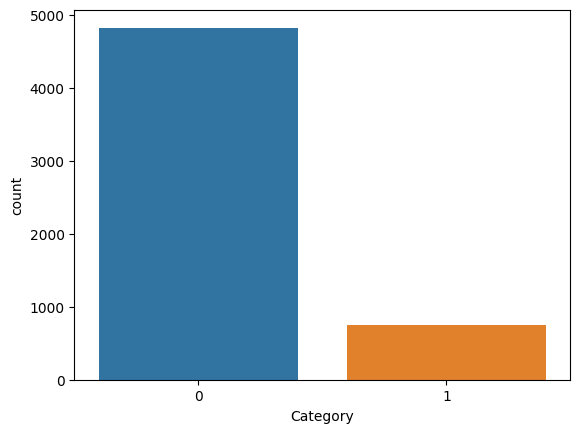

In [ ]:
sns.countplot(x='Category', data=data)
plt.show()

<ipython-input-95-e9dc138b6fd2>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = ham_msg.append(spam_msg)\


Text(0.5, 0, 'Message types')

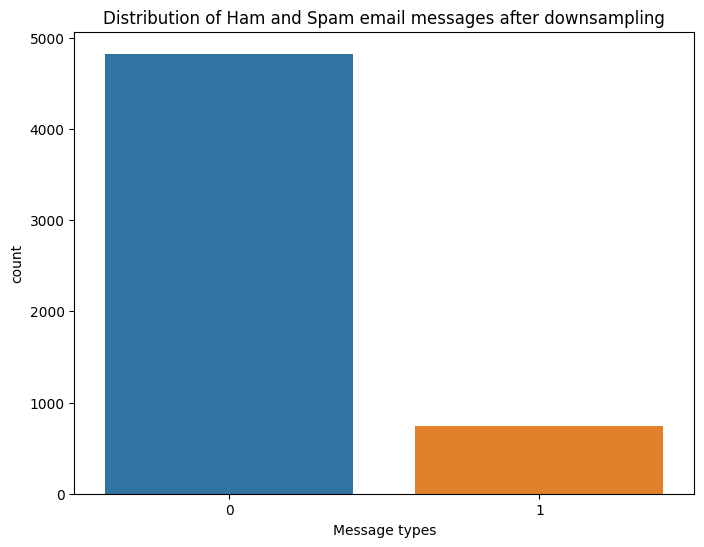

In [ ]:
# Downsampling to balance the dataset
ham_msg = data[data.Category == 0]
spam_msg = data[data.Category == 1]
# ham_msg = ham_msg.sample(n=len(spam_msg),
#                          random_state=42)         ## Wondering if I shouldn't downsample, and keep the ham messages the size that they are
 
# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='Category')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [ ]:
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject', '')
balanced_data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,0,Even my brother is not like to speak with me. ...


In [ ]:
punctuations_list = string.punctuation

In [ ]:
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

In [ ]:
balanced_data['Message'] = balanced_data['Message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Category,Message
0,0,Go until jurong point crazy Available only in ...
1,0,Ok lar Joking wif u oni
2,0,U dun say so early hor U c already then say
3,0,Nah I dont think he goes to usf he lives aroun...
4,0,Even my brother is not like to speak with me T...


In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)
    return output

In [ ]:
balanced_data['Message'] = balanced_data['Message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,0,u dun say early hor u c already say
3,0,nah dont think goes usf lives around though
4,0,even brother like speak treat like aids patent


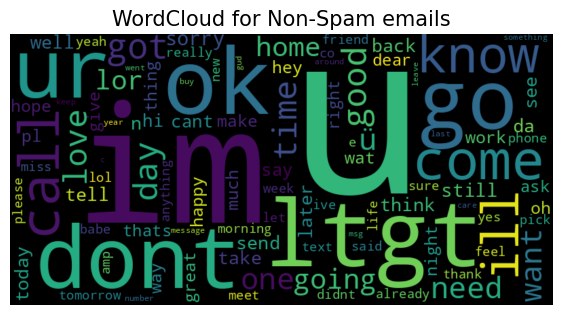

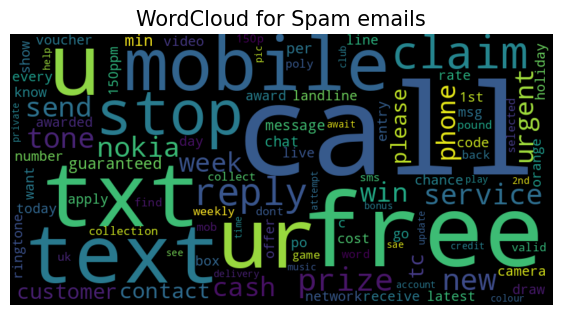

In [ ]:
email_corpus = " ".join(balanced_data[balanced_data['Category'] == 0]['Message'])
 
plt.figure(figsize=(7, 7))
 
wc = WordCloud(background_color='black', 
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)
 
plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Non-Spam emails', fontsize=15)
plt.axis('off')
plt.show()



email_corpus = " ".join(balanced_data[balanced_data['Category'] == 1]['Message'])
 
plt.figure(figsize=(7, 7))
 
wc = WordCloud(background_color='black', 
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)
 
plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Spam emails', fontsize=15)
plt.axis('off')
plt.show()

In [ ]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Message'],
                                                    balanced_data['Category'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
print("train_X.shape: ", train_X.shape)
print("test_X.shape:  ", test_X.shape)
print("train_Y.shape: ", train_Y.shape)
print("test_Y.shape:  ", test_Y.shape)

train_X.shape:  (4457,)
test_X.shape:   (1115,)
train_Y.shape:  (4457,)
test_Y.shape:   (1115,)


In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

**Model Development and Evaluation**

We will implement a Sequential model which will contain the following parts:

- Three Embedding Layers to learn featured vector representations of the input vectors.
- An LSTM layer to identify useful patterns in the sequence.
- Then we will have one fully connected layer.
- The final layer is the output layer which outputs probabilities for the two classes. 

In [ ]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           268064    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 271,777
Trainable params: 271,777
Non-trainable params: 0
_________________________________________________________________


**While compiling a model we provide these three essential parameters:**

- optimizer – This is the method that helps to optimize the cost function by using gradient descent.
- loss – The loss function by which we monitor whether the model is improving with training or not.
- metrics – This helps to evaluate the model by predicting the training and the validation data.

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

**Callback**

Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases the learning rate further? Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [ ]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
140/140 [==============================] - 9s 61ms/step - loss: 0.3920 - accuracy: 0.8676 - val_loss: 0.4066 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 8s 58ms/step - loss: 0.3918 - accuracy: 0.8676 - val_loss: 0.4075 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 9s 64ms/step - loss: 0.3915 - accuracy: 0.8676 - val_loss: 0.4076 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 8s 56ms/step - loss: 0.3913 - accuracy: 0.8676 - val_loss: 0.4071 - val_accuracy: 0.8592 - lr: 5.0000e-04


In [ ]:
# Train the model again with different epoch and batch sizes
# history2 = model.fit(train_sequences, train_Y,
#                     validation_data=(test_sequences, test_Y),
#                     epochs=20,
#                     batch_size=32,
#                     callbacks = [lr, es]
#                    )

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

print(f'\nThe training accuracy turns out to be {test_accuracy*100:.2f}%, which seems pretty good.')

35/35 [==============================] - 1s 24ms/step - loss: 0.4066 - accuracy: 0.8592
Test Loss : 0.4066051244735718
Test Accuracy : 0.8591928482055664

The training accuracy turns out to be 85.92%, which seems pretty good.


In [ ]:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()